<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/main/notebooks/Python_chapter_PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINNs (Physics Informed Neural Networks)

この章では、Physics-Informed Neural Network、通称PINNsについて紹介します。

2010年代から続くneural networkブームにおいて、我々は機械学習モデルが様々な分野でそれまでに実現できなかった高い精度で
いろんなタスクを解いたり、その補助をしてくれることを目撃してきました。  
すると当然のように沸き起こる疑問が「基礎方程式に従うhigh-fidelityなモデルを、データ駆動的なアプローチで解いたりできないか？」
というものです。


自然科学などの分野では  
「問題(の大部分)を説明する基礎方程式が既に定式化されているものの、実際にそれを数値的に解くのが難しい」
といった状況がしばしおこります。

Maziar Raissi, Paris Perdikaris, and George E. Karniadakis, "Physics-Informed Neural Networks: A Deep Learning Framework for Solving Forward and Inverse Problems Involving Nonlinear Partial Differential Equations", Journal of Computational Physics, 2019.

## PINNの概要

## Bethe-Weizsäcker formula

ここでは、例として原子核の結合エネルギーを計算する経験的な公式であるBethe-Weizsäcker formulaを考えよう。

ある$Z$個の陽子と$N$個の中性子を持つ原子核の結合エネルギー$E_B$は、次式で大まかに説明できることが知られている。
$$
\begin{align}
E_B &= a_V A - a_S A^{2/3} - a_C \frac{Z(Z-1)}{A^{1/3}} - a_\mathrm{sym.} \frac{(N-Z)^2}{4A} + \delta(A,Z)\\
\delta(A,Z) &=
\begin{cases}
a_p A^{-1/2} & \text{even-even nuclei}\\
-a_p A^{-1/2} & \text{odd-odd nuclei}\\
0 & otherwise
\end{cases}
\end{align}
$$
それぞれの項は体積項(volume term), 表面項(surface term), クーロン項(Coulomb term), 対称性項(symmetry term), ペアリング項(paring term)などと呼ばれる。 
これらの詳細は[Wikipedia](https://ja.wikipedia.org/wiki/ベーテ・ヴァイツゼッカーの公式)や原子核物理学の教科書に譲るとして、

この式をそれぞれ$Z$と$N$について偏微分すると  
$\frac{\partial E_B}{\partial Z} = a_V - \frac{2}{3} a_S A^{-1/3} - a_C \{ (2Z-1)A^{-1/3}-\frac{1}{3}Z(Z-1)A^{-4/3} \} - a_\mathrm{sym.} \{\frac{2(Z-N)}{4A} + \frac{(N-Z)^2}{4A^2} \} + \delta_Z(A,Z)$

$\frac{\partial E_B}{\partial N} = a_V - \frac{2}{3} a_S A^{-1/3} + a_C \{ \frac{Z(Z-1)}{4A^2} \} - a_\mathrm{sym.} \{\frac{2(N-Z)}{4A} + \frac{(N-Z)^2}{4A^2} \} + \delta_N(A,Z)$

という関係が得られる。

上の経験的な公式を$Z,N$の関数として表現した際、質量公式の出力値をいくつか訓練データとして使用し、
ニューラルネットワークを用いた代理モデルを構成し、テストデータに対する予測性能を調べてみよう。

なお各項につくパラメータ$a_V,a_S,a_C,a_\mathrm{sym.},a_p$については、以下のような文献値を使うことにする。

* $a_V$ = 15.67 MeV
* $a_S$ = 17.23 MeV
* $a_C$ = 0.714 MeV
* $a_\mathrm{sym.}$ = 93.15 MeV
* $a_p$ = 11.2 MeV

まず、質量公式を与える関数を自作し、データを適当に生成する。

In [174]:
def BW_formula(Z,N,typeof_return="E/A",der=""): # in MeV
    # coefficients 
    a_V = 15.67
    a_S = 17.23
    a_C = 0.714
    a_sym = 93.15
    a_p = 11.2

    A = Z+N
    delta_term = delta_term_der = delta_term_der_parA = 0.0
    if Z % 2 == 0 and N % 2 ==0:
        delta_term = a_p * A**(-1/2)
        delta_term_der = -1/2 * a_p * A**(-3/2)
        delta_term_der_parA = - 3/2 * a_p * A**(-5/2)
    if Z % 2 == 1 and N % 2 ==1:
        delta_term = -a_p * A**(-1/2)
        delta_term_der = 1/2 * a_p * A**(-3/2)
        delta_term_der_parA = 3/2 * a_p * A**(-5/2)
    BE = a_V * A - a_S * A**(2/3) - a_C * Z*(Z-1) / A**(1/3) - a_sym * (N-Z)**2 / (4*A) + delta_term
    if der == "":
        if typeof_return == "E/A":
            return BE/A
        elif typeof_return == "E":
            return BE
    elif der == "dEdZ":
        if typeof_return == "E/A":
            ret  = 1/3 * a_S * A**(-4/3) - a_C * ( (2*Z-1) / (A**(4/3)) -4/3 *Z*(Z-1) / (A**(7/3)) )
            ret += - a_sym * ( 2*(Z-N) / (4*A**2) - (N-Z)**2 / (2*A**3) ) + delta_term_der_parA
            return ret
        else: # may be wrong
            ret  = a_V - 2/3 * a_S * A**(-1/3) - a_C * (2*Z-1) * A**(-1/3) + a_C/3 * Z*(Z-1) * A**(-4/3) 
            ret -= a_sym * (2*(Z-N) / (4*A) + (N-Z)**2 / (4*A**2) ) + delta_term_der
            return ret
    elif der == "dEdN":
        if typeof_return == "E/A":
            ret  = 1/3 * a_S * A**(-4/3) + a_C * ( -4/3 * Z*(Z-1) / (A**(7/3)) )
            ret += -a_sym * (2*(N-Z) / (4*A*A) - (N-Z)**2 / (2*A**3) ) + delta_term_der_parA
            return ret
        else:
            ret  = a_V - 2/3 * a_S * A**(-1/3) + a_C * Z*(Z-1) / (4* A**2)
            ret -= a_sym * (2*(N-Z) / (4*A) + (N-Z)**2 / (4*A**2) ) + delta_term_der
            return ret  
    else:
        print(typeof_return, "not supported!")      
        exit()

print("He4", BW_formula(2,2), "O16", BW_formula(8,8) )

# ZとNの最大値を100として、可能な組み合わせ全てについて質量公式の値を計算しておく。
Zmax = Nmax = 100
Data = [ ]
for Z in range(Zmax):
    for N in range(Nmax):
        if  Z + N == 0:
            continue
        Data += [ [Z,N,BW_formula(Z,N)] ]

He4 5.990884247749431 O16 8.01554116142985


In [175]:
import numpy as np

# 結果の再現性のためseedを固定
np.random.seed(1234)

# データの配分を決める
rate_train_data = 0.05
rate_test_data = 1 - rate_train_data

# データのシャッフル
idxs = np.random.choice(range(len(Data)),len(Data),replace=False)
idx = int(len(Data)*rate_train_data)
idxs_train = idxs[:idx]
idxs_test = idxs[idx:]

data_train = [ Data[idx] for idx in idxs_train]
data_test = [ Data[idx] for idx in idxs_test]

print("# of data train:", len(data_train),"test:",len(data_test))

# of data train: 499 test: 9500


## ニューラルネットワークの構築

適当な構造を持ったニューラルネットワークを作ってみよう。  
ここでは、PyTorchを用いることにする。

Epoch:     100 MSE 1.580e-01 MSE' 9.870e-01
Epoch:     200 MSE 1.782e-01 MSE' 3.743e+00
Epoch:     300 MSE 8.928e-02 MSE' 1.113e+01
Epoch:     400 MSE 6.866e-02 MSE' 6.100e+00
Epoch:     500 MSE 1.654e-01 MSE' 2.706e+00
Epoch:     600 MSE 3.408e-01 MSE' 4.405e+00
Epoch:     700 MSE 1.870e-01 MSE' 4.903e+00
Epoch:     800 MSE 4.555e-01 MSE' 1.529e+01
Epoch:     900 MSE 2.055e-01 MSE' 4.608e+00
Epoch:    1000 MSE 2.253e-01 MSE' 8.357e+00
Epoch:    1100 MSE 6.241e-02 MSE' 1.512e+00
Epoch:    1200 MSE 2.299e-01 MSE' 6.178e+00
Epoch:    1300 MSE 1.533e-01 MSE' 1.589e+00
Epoch:    1400 MSE 6.166e-02 MSE' 6.254e+00
Epoch:    1500 MSE 1.323e-01 MSE' 5.924e+00
Epoch:    1600 MSE 1.090e-01 MSE' 1.842e+00
Epoch:    1700 MSE 7.916e-01 MSE' 6.346e-01
Epoch:    1800 MSE 2.372e-01 MSE' 9.507e+00
Epoch:    1900 MSE 2.092e-01 MSE' 7.943e+01
Epoch:    2000 MSE 8.917e-02 MSE' 3.725e+00
Epoch:    2100 MSE 1.217e+00 MSE' 6.235e+00
Epoch:    2200 MSE 1.716e-01 MSE' 2.563e+00
Epoch:    2300 MSE 1.480e-01 MSE

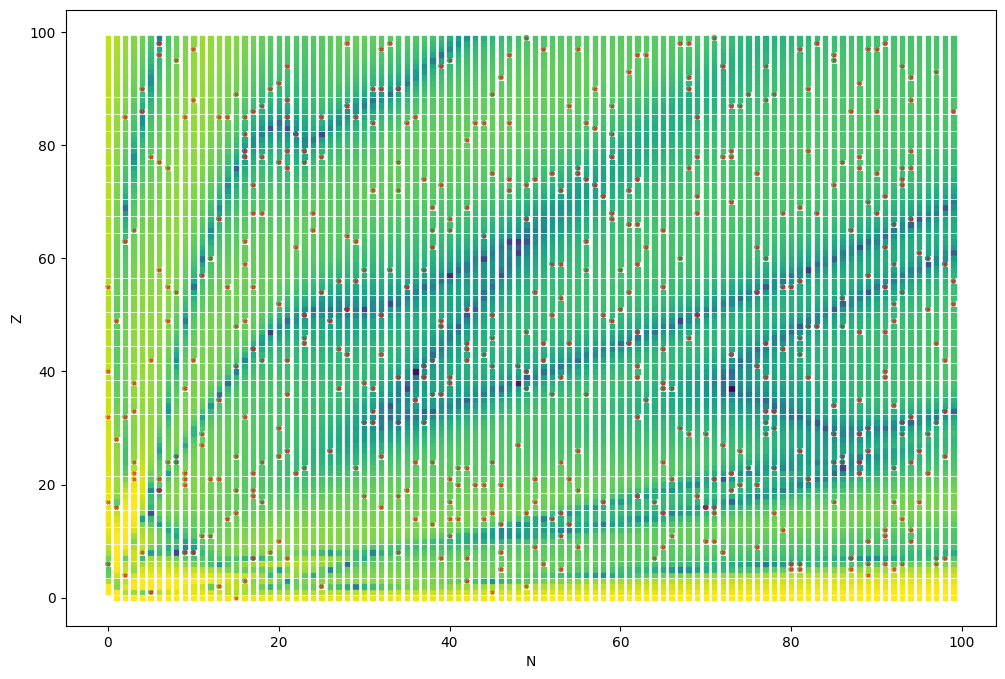

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
from pytorch_memlab import profile
import seaborn as sns
sns.set_style()

class DataSet:
    def __init__(self,data_train,data_test,normalize=True):
        self.ntrain = len(data_train)
        self.ntest = len(data_test)
        self.data_train = np.array(data_train).T
        self.data_test = np.array(data_test).T
        self.normalize = normalize
        self.x_train = self.data_train[0:2,:].T; self.y_train = self.data_train[2:,:].T
        self.x_test = self.data_test[0:2,:].T;   self.y_test = self.data_test[2:,:].T
        self.ymean = 0.0
        self.ystd = 1.0
        if self.normalize:
            self.ymean = np.mean(self.y_train)
            self.ystd = np.std(self.y_train)
            self.y_train -= self.ymean
            self.y_test -= self.ymean
            self.y_train /= self.ystd
            self.y_test /= self.ystd

    def load_data(self):
        x_train = torch.tensor(self.x_train,dtype=torch.float32,requires_grad=True)
        y_train = torch.tensor(self.y_train,dtype=torch.float32)
        x_test = torch.tensor(self.x_test,dtype=torch.float32)
        y_test = torch.tensor(self.y_test,dtype=torch.float32)
        return x_train, y_train, x_test, y_test

class PINN(nn.Module):
    def __init__(self, num_nodes = 64):
        super(PINN, self).__init__()
        self.biasTF = True
        self.input_dim = 2
        self.output_dim = 1
        self.num_node = 32

        self.fc_inp = nn.Linear(self.input_dim, self.num_node)
        self.hl1 = nn.Linear(self.num_node,self.num_node)
        self.act = nn.Softplus()
        #self.act = nn.Sigmoid()
        self.act_hl = nn.ELU()
        self.hl2 = nn.Linear(self.num_node,self.num_node)
        self.hl_edge = nn.Linear(self.num_node,self.num_node)
        self.fc_out = nn.Linear(self.num_node, self.output_dim, bias=False)

    def forward(self, x):
        out = self.act(self.fc_inp(x))
        out = self.act_hl(self.hl1(out))
        out = self.act_hl(self.hl2(out))
        out = self.act_hl(self.hl_edge(out))
        out = self.fc_out(out)
        return out

    def __call__(self, inp):
        return self.forward(inp)

    def loss_mse(self, x, y,ynn):
        return nn.MSELoss()(ynn,y)

    def loss_der(self, x_in, ynn, eps=1.e-4):
        lossval = 0.0
        idxs = np.random.choice(range(ynn.shape[0]),int(0.05*ynn.shape[0]),replace=False)
        for n in idxs:
            x = x_in[n,:]
            y = self(x)
            dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)
            u_Z = BW_formula(x[0],x[1],der="dEdZ")
            u_N = BW_formula(x[0],x[1],der="dEdN")
            lossval += nn.MSELoss()(dy_dx[0][0],u_Z) + nn.MSELoss()(dy_dx[0][1],u_N)
        
        return lossval   
    
"""
mainplot

function to plot heatmap
"""
def mainplot(x_train,y_train,x_test,y_test,y_mean,y_std,yNN_train,yNN_test):
    x_train = x_train.detach().numpy()
    y_train = y_train.detach().numpy()
    x_test = x_test.detach().numpy()
    y_test = y_test.detach().numpy()
    #y_train = y_train * y_std + y_mean
    #y_test = y_test * y_std + y_mean
    #yNN_train = yNN_train * y_std + y_mean
    #yNN_test = yNN_test * y_std + y_mean

    #err_train = np.log10( [1.e-10 + (y_train[n] - BW_formula(x_train[n,0],x_train[n,1],"E"))**2 for n in range(len(y_train))])
    #err_test =  np.log10( [1.e-10 + (y_test[n] - BW_formula(x_test[n,0],x_test[n,1],"E"))**2 for n in range(len(y_test))])
    err_train = np.log10( np.array([ (yNN_train[n] - y_train[n])**2 for n in range(len(y_train))]) + 1.e-10)
    err_test =  np.log10( np.array([ (yNN_test[n] - y_test[n])**2 for n in range(len(y_test))]) + 1.e-10)
    vmin = -10
    vmax = 1

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.scatter(x_train[:,1],x_train[:,0],c=err_train,vmin=vmin,vmax=vmax,marker="o",cmap="viridis",s=10)
    ax.scatter(x_test[:,1],x_test[:,0],c=err_test,vmin=vmin,vmax=vmax,marker="s",cmap="viridis",s=10)    
    ax.scatter(x_train[:,1],x_train[:,0],marker="x",color="r", s=5, alpha=0.6)
    ax.set_xlabel("N")
    ax.set_ylabel("Z")    
    plt.savefig("BW_heatmap.pdf")
    plt.show()
    plt.close()

if __name__ == '__main__' :
    # データをPyTorch用に整形
    mydata = DataSet(data_train,data_test)
    x_train,y_train,x_test,y_test = mydata.load_data()
    y_std = mydata.ystd
    y_mean = mydata.ymean

    # ハイパラ
    num_epochs = 5000
    num_epoch_show = 100
    learning_rate = 3.e-3
    lam_der = 1.e-1
    wd = 1.e-2
    use_der = False
    use_der = True

    # 可能ならcudaを使用
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 乱数シードの固定
    seed = 123
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms = True
    #torch.backends.cudnn.benchmark = False
                  
    # モデルの定義
    model = PINN().to(device)

    # 最適化手法の選択
    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=wd)
    #optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    #optimizer = torch.optim.SGD(model.parameters(), lr = 0.1 ,momentum=0.9,weight_decay=wd) 
              
    # モデルの学習
    model.train()
    bestloss = 1.e+10
    for epoch in range(1,num_epochs+1):
        x = x_train.to(device)
        y = y_train.to(device)
        ynn = model(x)
        optimizer.zero_grad(set_to_none=True)
        loss_mse = model.loss_mse(x,y,ynn)
        loss_der = model.loss_der(x,ynn)
        if use_der:            
            loss = loss_mse + lam_der * loss_der 
        else:
            loss = loss_mse
        if epoch % num_epoch_show == 0:
            print("Epoch: ",str("%6i" % epoch), "MSE",str("%9.3e" % loss_mse.item()), "MSE'", str("%9.3e" % loss_der.item()))    
        loss.backward()
        optimizer.step()
        if loss.item() < bestloss:
            bestloss = loss.item()
            torch.save(model.state_dict(), 'best_model.pth')

    # モデルの評価
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    x = x_train.to(device)
    y = y_train.to(device)
    yNN_train = model(x)
    trainloss = nn.MSELoss()(yNN_train,y).item()
    yNN_train = yNN_train.cpu().detach().numpy()
    print("trainloss:", str("%9.3e" % trainloss))
    
    print("test:")
    x = x_test.to(device)
    y = y_test.to(device)
    yNN = model(x)
    testloss = nn.MSELoss()(yNN,y).item()
    yNN_test = yNN.cpu().detach().numpy()
    print("testloss:",str("%9.3e" % testloss))

    mainplot(x_train,y_train,x_test,y_test,y_mean,y_std,yNN_train,yNN_test)